### Import Libraries

In [1]:
# General
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Hide future warnings
import warnings
warnings.filterwarnings('ignore')

# Custom functions
import sys
sys.path.append('../libraries')
import modelling_helper_functions as mod

----

### Import Data

In [2]:
# Read CSV.
df_earth_vitals = pd.read_csv('../data/cleaned/earth_vitals.csv',index_col=0)

# Reset index to datetime format.
df_earth_vitals.index = pd.to_datetime(df_earth_vitals.index)

# Drop sea ice extent data as discussed in the EDA notebook.
df_earth_vitals.drop('global_sea_ice_extent',axis=1,inplace=True)

In [3]:
# Check data.
df_earth_vitals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2002-04-30 to 2022-11-30
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sea_temp_anomaly             248 non-null    float64
 1   total_ice_sheet_mass_change  248 non-null    float64
 2   global_mean_sea_level        248 non-null    float64
dtypes: float64(3)
memory usage: 7.8 KB


----

### Split Test/Train and X/y

In [4]:
# Split off approx 20% of the data to use as a test set.
remainder = df_earth_vitals.loc[df_earth_vitals.index <= "2019-01-01"]
test = df_earth_vitals.loc[df_earth_vitals.index > "2019-01-01"]

In [5]:
# Split the remainder in to X and y.
X_remainder = remainder.drop('global_mean_sea_level',axis=1).copy()
y_remainder = remainder['global_mean_sea_level']

# Split the test set in to X and y.
X_test = test.drop('global_mean_sea_level',axis=1).copy()
y_test = test['global_mean_sea_level']

----

### Baseline Model

To begin, i'll simply take the average reading of the yearly differenced data to make predictions on. It's unlikely to be particularly accurate, but it'll give me a minimum accuracy to work from going forwards to more complex models.

To calculate accuracy i'll use the mean absolute percentage error, as it is more interpretable than some other metrics commonly used.

In [6]:
# Create 12-month differenced data to use.
y = df_earth_vitals['global_mean_sea_level'].diff(12).dropna()

In [7]:
# Split test and train.
y_remainder_diff = y.loc[y.index <= "2019-01-01"]
y_test_diff = y.loc[y.index > "2019-01-01"]

In [8]:
# Create baseline predictions by taking the mean value from the remainder.
base_line = np.full(y.index.shape, np.mean(y_remainder_diff))
predictions = pd.Series(data=base_line, index=y.index)

In [9]:
# Plot train, test and predicted values.
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_remainder_diff.index, y=y_remainder_diff, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test_diff.index, y=y_test_diff, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Mean Prediction"))

fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Change in GMSL over Prior Year"
)
fig.show()

In [10]:
# Evaluate model based on test data.
y_pred = pd.Series(data=predictions, index=y_test_diff.index)
mod.metrics_summary('Mean',y_test_diff,y_pred)

Results for the test data:
	Model: Mean
	MAPE = 595.435%


As expected, this model gives us a very poor result. However, going forwards, i'll be able to evaluate my other models against this one to see whether they are better than simply guessing the average value for each input.

----

### Linear Regression

For my first complex model i'll use linear regression. I'll first scale my X variables, then use a grid search to look through different variations of linear model (LinearRegression, RidgeRegression and LassoRegression) to see which gives the best results.

I'll also include the options of PCA to see if a reduction in dimensionality helps the model at all. Given i only have two X variables, i don't think PCA will be hugely useful in this scenario, but given the simplicity of the model the increased computing power will be negligible so i might as well check.

I'll also use TimeSeriesSplit to cross-validate my data during the fitting process.

In [11]:
# Instantiate and fit scalar.
scaler = StandardScaler().fit(X_remainder)

# Transform data.
X_remainder_s = scaler.transform(X_remainder)
X_test_s = scaler.transform(X_test)

In [12]:
# Set up pipeline of operations.
estimators = [('dim_reduction',PCA()),
              ('model',LinearRegression())]
pipeline = Pipeline(estimators)

# Define parameter grid.
param_grid = [{'model':[LinearRegression(),Ridge(),Lasso()],
               'dim_reduction':[PCA()],
               'dim_reduction__n_components':[1,2]},
               
               {'model':[LinearRegression(),Ridge(),Lasso()],
               'dim_reduction':[None]}]

# Set up grid search to include 
grid = GridSearchCV(pipeline,param_grid,cv=TimeSeriesSplit(n_splits=5),scoring='neg_mean_absolute_percentage_error',verbose=1)

In [13]:
# Fit grid search.
fitted_search = grid.fit(X_remainder_s, y_remainder)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [14]:
# Check best parameters.
fitted_search.best_estimator_

Pipeline(steps=[('dim_reduction', None), ('model', Ridge())])

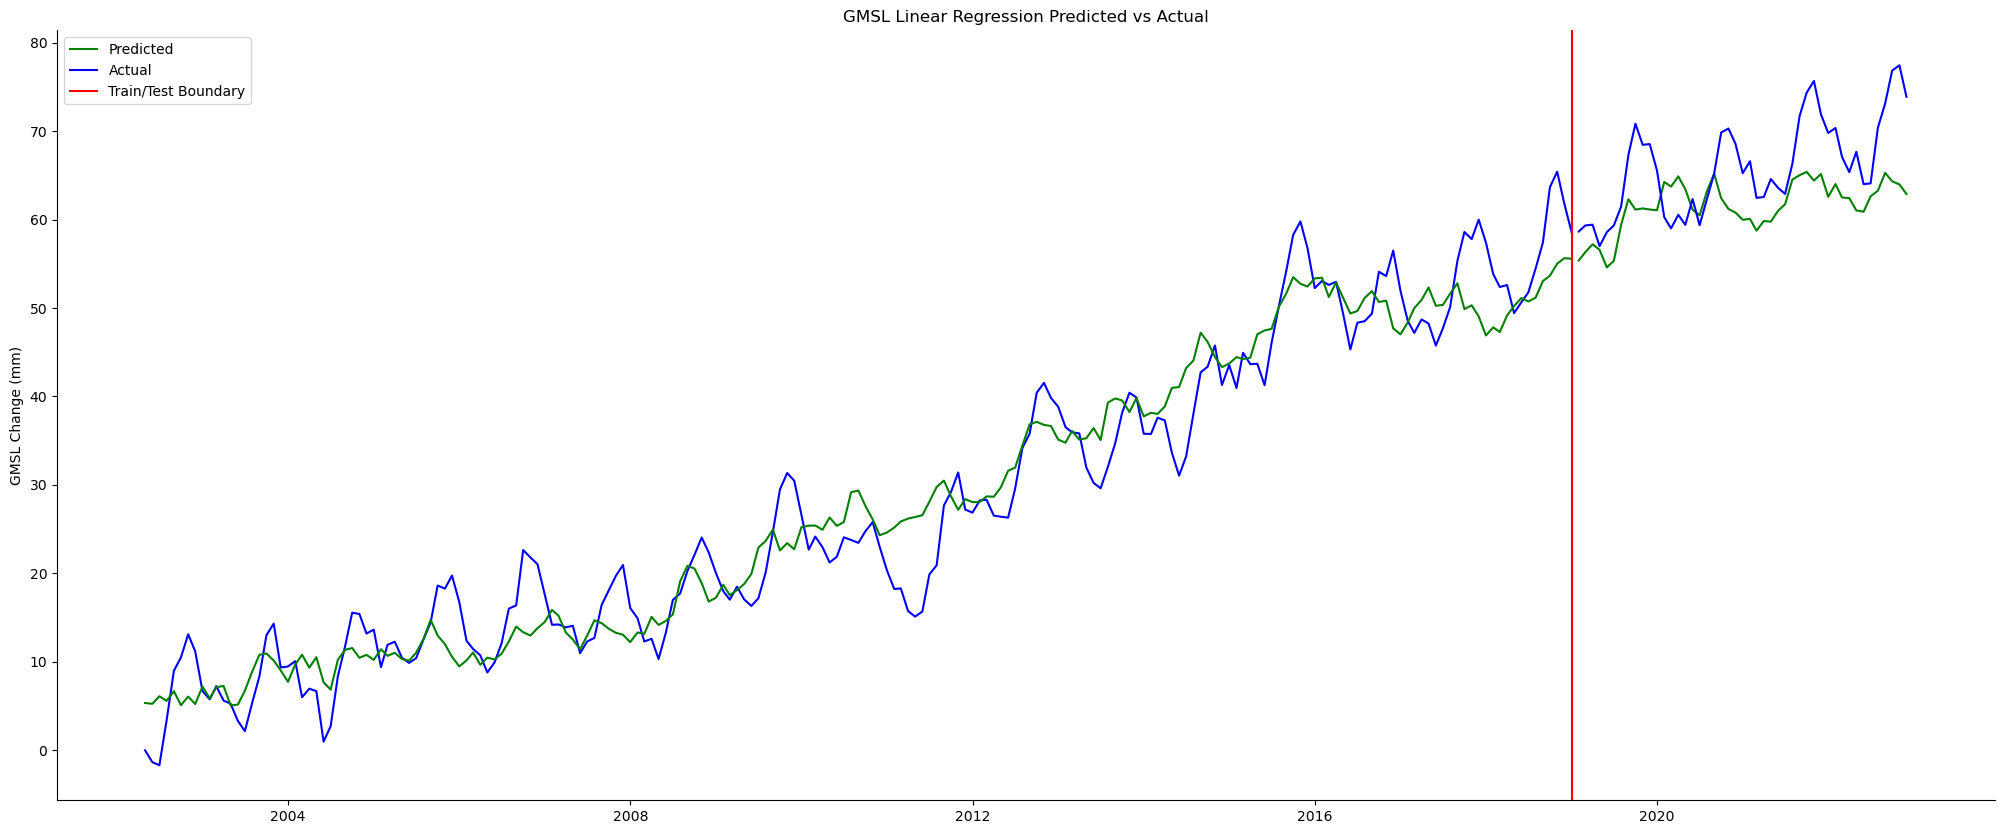

Results for the test data:
	Model: Pipeline(steps=[('dim_reduction', None), ('model', Ridge())])
	MAPE = 7.596%


In [15]:
# Predict values for the test and remainder sets.
y_pred = fitted_search.predict(X_test_s)
y_rem_pred = fitted_search.predict(X_remainder_s)

# Create dataframes with datetime index.
y_pred = pd.DataFrame(y_pred,index=y_test.index)
y_rem_pred = pd.DataFrame(y_rem_pred,index=y_remainder.index)

# Plot and score the predicted values.
mod.lin_reg_plot(y_remainder,y_rem_pred,y_test,y_pred)
mod.metrics_summary(fitted_search.best_estimator_,y_test,y_pred)

The MAPE has improved massively to just 7.6%, a huge improvement on the baseline model. It also looks like the model has generalised pretty well across all the datapoints, and hasn't become too overfitted on the training data.

However, the model looks to be underestimating the trend of the values in the test set, despite getting the pattern fairly accurate. It looks as though the rate of sea level rise accelerate slightly in around 2009, then starts to slow again around 2018. It's possible that the model picked up on this gradual deceleration and overestimated the rate at which it would continue.

While this model is usable, it only takes in to account the exogenous variables, ice sheet mass change and sea temp anomalies, that i have provided it. It doesn't use any of the features of the target variable itself.

----

### SARIMAX

To improve the accuracy further, i'd like to implement a SARIMAX model, so that i can take in to account the pattern in the global mean sea level data itself.

#### Differencing Required for Stationarity

It was established during the EDA that the data wasn't stationary, and therefore would need differencing in order to be fed in to a SARIMAX model. I'll take a look now at how many times the data needs to be differenced in order to achieve that stationarity and therefore the 'd' value for my model.

In [16]:
sea_level_diff_df = pd.DataFrame(index=df_earth_vitals.index,data={'sea_level_diff':df_earth_vitals['global_mean_sea_level'].diff(12)}).dropna()

In [17]:
fig = px.line(sea_level_diff_df, x=sea_level_diff_df.index, y="sea_level_diff")
fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Sea Level 12-month Difference"
)
fig.show()

adf_stationarity = adfuller(sea_level_diff_df)
kpss_stationarity = kpss(sea_level_diff_df)

print(f'ADFuller Test p_value: {adf_stationarity[1]:.4f}')
print(f'KPSS Test p_value: {kpss_stationarity[1]:.4f}')

ADFuller Test p_value: 0.0013
KPSS Test p_value: 0.1000


The ADFuller null hypothesis is that the distribution is non-stationary, and the opposite for the KPSS test. The p_values above confirm that the distribution is stationary after 1 difference, and therefore the 'd' value for the SARIMAX model can be set at 1.

#### Check Autocorrelation

To find the 'q' value for the model, i'll need to check how many lags fall outside the 95% confidence interval, which suggests that they are correlated to the value.

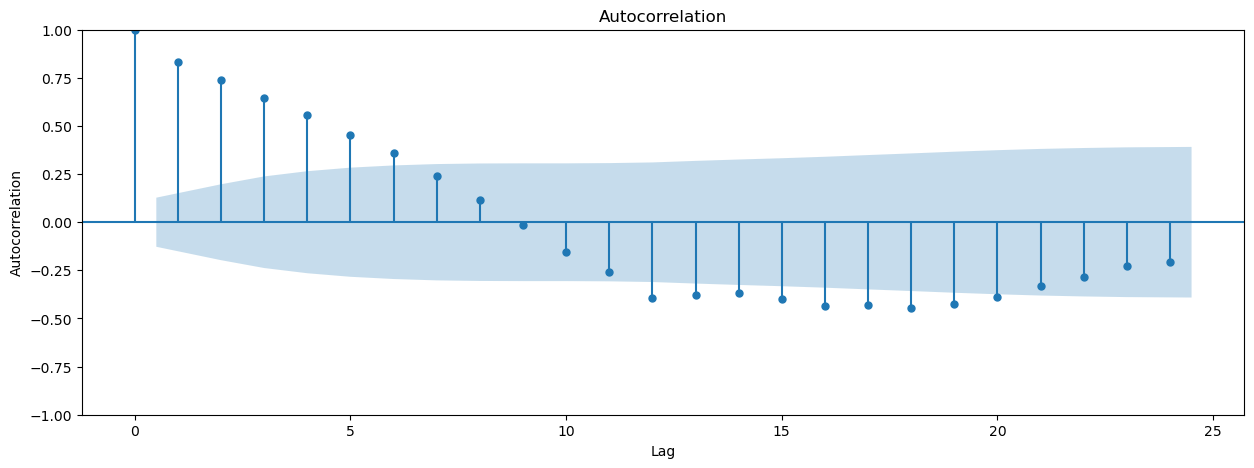

In [18]:
# Plot autocorrelation
plt.figure(figsize=(15, 5))
plot_acf(sea_level_diff_df['sea_level_diff'], lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

It looks like the 'q' value in the SARIMAX model will need to be set at 5 or 6 (the 6th lag is quite close to the confidence interval). I will need to test both to check which is better.

#### Check Partial Autocorrelation

Finally, to determine the 'p' value in the model, i'll need to check the partial autocorrelation graph of the data.

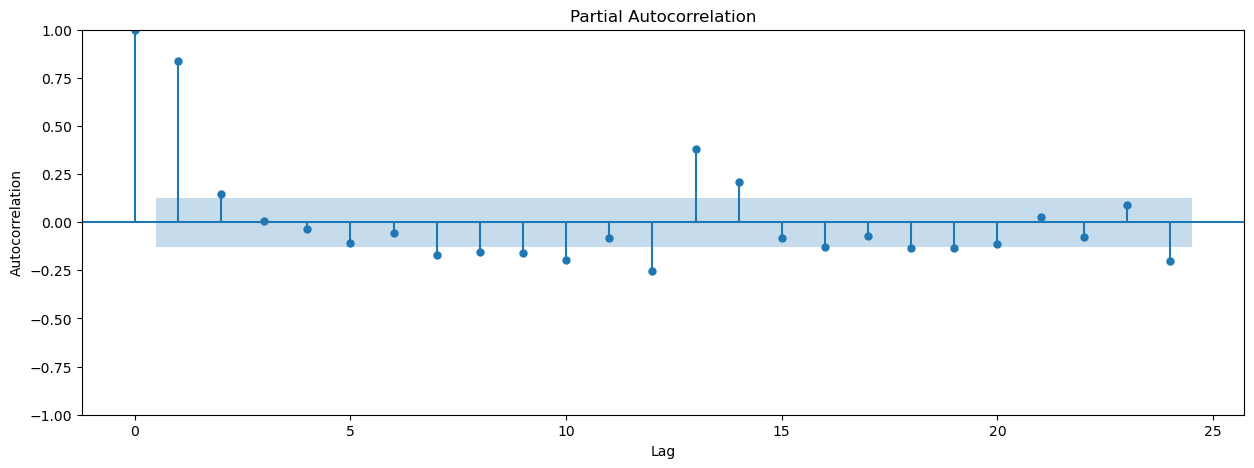

In [19]:
# Plot partial autocorrelation.
plt.figure(figsize=(15, 5))
plot_pacf(sea_level_diff_df['sea_level_diff'], lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Here we can clearly see that the 'p' value in the SARIMAX model will need to be set to 1.

#### Implement Model

Models to test:
- Check q values 5 vs 6 (excluding seasonality).
- Remove insignificant MA components.

##### Check q values

In [20]:
# Model and plot with q = 5
model_5 = SARIMAX(y_remainder, order=(1,1,5)).fit()

predictions_5 = model_5.predict(start=0, end=len(y_remainder)+len(y_test)-1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_remainder.index, y=y_remainder, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions_5.index, y=predictions_5, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Change in Sea Level, q = 5")
fig.show()

# Model and plot with q = 6
model_6 = SARIMAX(y_remainder, order=(1,1,6)).fit()

predictions_6 = model_6.predict(start=0, end=len(y_remainder)+len(y_test)-1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_remainder.index, y=y_remainder, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions_6.index, y=predictions_6, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Change in Sea Level, q = 6")
fig.show()

Looking at the graphs above, it is clear that having q = 6 means the model is able to follow the trend of the graph far better than q = 5, where it simply flatlines. We can now implement the model with the final p, d and q values to get a new score.

In [21]:
# Implement new model, predict test values and score model.
model = SARIMAX(y_remainder, order=(1,1,6)).fit()

predictions = model.predict(start=len(y_remainder)+1, end=len(y_remainder)+len(y_test))

mod.metrics_summary(model,y_test,predictions)

Results for the test data:
	Model: <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000017228108880>
	MAPE = 5.06%


The new model has improved the MAPE to approx. 5%, which is good.

#### Check MA values

Now that the p, d and q values have been set for the model, i can take a look at the p-values for the various components of the model, to see what is contributing to the model and what isn't. If an element isn't contributing much to the model i'll remove it to simplify the model, so long as the scoring isn't impacted.

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     global_mean_sea_level   No. Observations:                  201
Model:                  SARIMAX(1, 1, 6)   Log Likelihood                -458.218
Date:                   Tue, 11 Apr 2023   AIC                            932.437
Time:                           08:13:29   BIC                            958.823
Sample:                       04-30-2002   HQIC                           943.115
                            - 12-31-2018                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9985      0.005    193.003      0.000       0.988       1.009
ma.L1         -0.8593      0.072    -11.990      0.000      -1.000      -0.719
ma.L2         -0.1668      0.094     -1.779      0.075      -0.350       0.017
ma.L3         -0.2285      0.101     -2.268      0.023      -0.426      -0.031
ma.L4          0.0108      0.102      0.107      0.915      -0.189       0.210
ma.L5         -0.0766      0.098     -0.784      0.433      -0.268       0.115
ma.L6          0.3266      0.062      5.248      0.000       0.205       0.449
sigma2         5.6474      0.682      8.284      0.000       4.311       6.984
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.89
Prob(Q):                              0.69   Prob(JB):                         0.24
Heteroskedasticity (H):               1.26   Skew:                            -0.05
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It can be seen here that there are several MA values that are insignificant in the model. 

After iterating over the model a couple of times, and checking the score each time, i have found that by removing the 4th and 5th lags all the p-values are brought under the 0.05 threshold, and the model has actually improved fractionally.

In [23]:
# Implement new model, predict test values and score model.
model = SARIMAX(y_remainder, order=(1,1,[1,2,3,6])).fit()

predictions = model.predict(start=len(y_remainder)+1, end=len(y_remainder)+len(y_test))

mod.metrics_summary(model,y_test,predictions)

Results for the test data:
	Model: <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000017228CC01C0>
	MAPE = 5.047%


#### Introduce Seasonality

Now i will introduce seasonality to the model to try and improve the fit, as currently the model just plots a stright line through the test data.

In [24]:
# Fit model.
seasonal_model = SARIMAX(y_remainder, order=(1,1,[1,2,3,6]), seasonal_order=(1, 1, 1, 12)).fit()

# Make predictions for remainder and test data.
predictions = seasonal_model.predict(start=0, end=len(y_remainder)+len(y_test)-1)

# Plot observed data and predictions.
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_remainder.index, y=y_remainder, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Change in Sea Level"
)
fig.show()

In [25]:
# Make predictions for test data.
predictions = seasonal_model.predict(start=len(y_remainder)+1, end=len(y_remainder)+len(y_test))

# Score predictions.
mod.metrics_summary(seasonal_model,y_test,predictions)

Results for the test data:
	Model: <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000017228C98190>
	MAPE = 3.384%


The score has improved again! I will now train the same model on the whole dataset (test and train) so that i can use it to make future predictions.

In [26]:
# Take the full set of values for the target variable.
y = df_earth_vitals['global_mean_sea_level']

In [27]:
# Train model on full set of values.
seasonal_model = SARIMAX(y, order=(1,1,[1,2,3,6]), seasonal_order=(1, 1, 1, 12)).fit()

#### Introduce Exogenous Variables

As a final step, i will reintroduce the exogenous variables to see if the score can be improved any further.

In [28]:
# Fit model
exog_model = SARIMAX(y_remainder, order=(1,1,[1,2,3,6]), seasonal_order=(1, 1, 1, 12),exog=X_remainder).fit()

# Make predictions for train and test data.
predictions = exog_model.predict(start=X_remainder.index[0],end=X_test.index[-1],exog=X_test)

# Visualize observed and predicted values.
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_remainder.index, y=y_remainder, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Change in Sea Level"
)
fig.show()

In [29]:
# Make predictions on test data.
predictions = exog_model.predict(start=y_test.index[0], end=y_test.index[-1],exog=X_test)

# Score test predictions.
mod.metrics_summary(exog_model,y_test,predictions)

Results for the test data:
	Model: <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001722778E340>
	MAPE = 2.675%


The model has improved again, which is great news. I now have a model which will be able to accurately predict future sea level rise. As before, i will retrain the model on the full data set to use for predictions.

In [30]:
# Extract full range of independent variable values.
X = df_earth_vitals.drop('global_mean_sea_level',axis=1)

In [31]:
# Train model on full set of values.
exog_model = SARIMAX(y, order=(1,1,[1,2,3,6]), seasonal_order=(1, 1, 1, 12),exog=X).fit()

----

### Predictions with Seasonal Model

I can now make some predictions using the two models i've created. I'll begin by looking at the seasonal model, which doesn't use any exogenous variables.

In [32]:
# Predict values.
seasonal_predictions = seasonal_model.predict(start=df_earth_vitals.index[0], end=len(df_earth_vitals)*2)

# Plot observed data and predictions.
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_earth_vitals.index, y=df_earth_vitals['global_mean_sea_level'], mode='lines', name="Observed"))
fig.add_trace(go.Scatter(x=seasonal_predictions.index, y=seasonal_predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Change in Sea Level"
)
fig.show()

Without the benefit of exogenous variables to guide its prediction, this model just uses the historical pattern of the target variable to predict future values. This is one of the main drawbacks of this model - providing accurate and usable information relies on providing long-term forecasts of sea level, but this model is limited by its lack of ability to draw from external data, and therefore, after the first year of predicted data, the pattern simply repeats itself, because it isn't being fed any new or varied information.

However, it does give us a good estimate of what "all things remaining equal" sea level might look like over the next 20 years.

----

### Predictions with Exogenous Model

In order to use the exogenous model, i will need to create some hypothetical data for the exogenous variables. In this example i will create data assuming that ice mass loss is limited to 12,000 gigatonnes over the next 20 years, and ocean warming stays within 1 degree, less than double the changes than have occurred over the last 20 years. This should influence the predictions downwards.

In [33]:
# Create exogenous variable dataframe.
X_target = pd.DataFrame(columns=['date','sea_temp_anomaly','total_ice_sheet_mass_change'])

# Input the final reading of the observed values, and the target variables and date.
X_target = X_target.append({'date':df_earth_vitals.index[-1],'sea_temp_anomaly':df_earth_vitals.values[-1][0],'total_ice_sheet_mass_change':df_earth_vitals.values[-1][1]},ignore_index=True)
X_target = X_target.append({'date':'2043-08-31','sea_temp_anomaly':1,'total_ice_sheet_mass_change':-12000},ignore_index=True)

# Set date to datetime and set as index.
X_target['date'] = pd.to_datetime(X_target['date'])
X_target.set_index('date',inplace=True)

# Fill missing values between the two dates and interpolate the variables.
X_target = X_target.reindex(pd.date_range(X_target.index[0],X_target.index[-1]))
X_target[['sea_temp_anomaly','total_ice_sheet_mass_change']] = X_target[['sea_temp_anomaly','total_ice_sheet_mass_change']].interpolate()

# Resample to monthly readings.
X_target = X_target.resample('M').mean()

# Drop the first value (originally taken from observed data).
X_target.drop('2022-11-30',inplace=True)

In [34]:
# Make predictions.
exog_predictions = exog_model.predict(start=df_earth_vitals.index[0], end=len(df_earth_vitals)*2,exog=X_target)

# Plot observed data and predictions.
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_earth_vitals.index, y=df_earth_vitals['global_mean_sea_level'], mode='lines', name="Observed"))
fig.add_trace(go.Scatter(x=exog_predictions.index, y=exog_predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="Difference (mm)", 
    xaxis_title="Date",
    title="Change in Sea Level"
)
fig.show()

As predicted, the presence of the exogenous variables has influenced the data slightly lower than it otherwise would have been; the final reading for the seasonal model has GMSL at a 141mm increase, while the exogenous model has the final reading at 135mm. This is useful when looking at potential targets in order to limit sea level rise, but any predictions should be used carefully, as a prediction based on a prediction make the model increasingly unreliable.

----